In [1]:
import gc
import pickle
import numpy as np 
import pandas as pd 
from category_encoders.ordinal import OrdinalEncoder
import matplotlib.pyplot as plt
from tsforest.utils import make_time_range

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***
## data loading

In [2]:
sales_train = pd.read_csv("../input/sales_train_validation.csv")
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [3]:
calendar = pd.read_csv("../input/calendar.csv", parse_dates=["date"])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [4]:
sell_prices = pd.read_csv("../input/sell_prices.csv")
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


***
## hierarchy

In [5]:
sales_train["id"] = sales_train.id.map(lambda x: x.replace("_validation", ""))
hierarchy = (sales_train.loc[:, ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]]
             .drop_duplicates())
encoders = dict()

In [6]:
hierarchy.to_parquet("../input/hierarchy_raw.parquet", index=False)

/home/turing/miniconda/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
# hierarchy encoder
id_encoder = OrdinalEncoder()
id_encoder.fit(hierarchy.loc[:, ["id"]])
hierarchy["ts_id"]  = id_encoder.transform(hierarchy.loc[:, ["id"]])
encoders["id"] = id_encoder

item_encoder = OrdinalEncoder()
item_encoder.fit(hierarchy.loc[:, ["item_id"]])
hierarchy.loc[:, "item_id"]  = item_encoder.transform(hierarchy.loc[:, ["item_id"]])
encoders["item"] = item_encoder

dept_encoder = OrdinalEncoder()
dept_encoder.fit(hierarchy.loc[:, ["dept_id"]])
hierarchy.loc[:, "dept_id"]  = dept_encoder.transform(hierarchy.loc[:, ["dept_id"]])
encoders["dept"] = dept_encoder

cat_encoder = OrdinalEncoder()
cat_encoder.fit(hierarchy.loc[:, ["cat_id"]])
hierarchy.loc[:, "cat_id"]   = cat_encoder.transform(hierarchy.loc[:, ["cat_id"]])
encoders["cat"] = cat_encoder

store_encoder = OrdinalEncoder()
store_encoder.fit(hierarchy.loc[:, ["store_id"]])
hierarchy.loc[:, "store_id"] = store_encoder.transform(hierarchy.loc[:, ["store_id"]])
encoders["store"] = store_encoder

state_encoder = OrdinalEncoder()
state_encoder.fit(hierarchy.loc[:, ["state_id"]])
hierarchy.loc[:, "state_id"] = state_encoder.transform(hierarchy.loc[:, ["state_id"]])
encoders["state"] = state_encoder

In [8]:
hierarchy.to_parquet("../input/hierarchy.parquet", index=False)

In [9]:
outfile = open("../input/encoders.pkl", "wb")
pickle.dump(encoders, outfile)
outfile.close()

***
## calendar events encoding

In [10]:
event_name_1_encoder = OrdinalEncoder()
event_name_1_encoder.fit(calendar.loc[:, ["event_name_1"]])
calendar.loc[:, "event_name_1"] = event_name_1_encoder.transform(calendar.loc[:, ["event_name_1"]])

In [11]:
event_type_1_encoder = OrdinalEncoder()
event_type_1_encoder.fit(calendar.loc[:, ["event_type_1"]])
calendar.loc[:, "event_type_1"] = event_type_1_encoder.transform(calendar.loc[:, ["event_type_1"]])

In [12]:
event_name_2_encoder = OrdinalEncoder()
event_name_2_encoder.fit(calendar.loc[:, ["event_name_2"]])
calendar.loc[:, "event_name_2"] = event_name_2_encoder.transform(calendar.loc[:, ["event_name_2"]])

In [13]:
event_type_2_encoder = OrdinalEncoder()
event_type_2_encoder.fit(calendar.loc[:, ["event_type_2"]])
calendar.loc[:, "event_type_2"] = event_type_2_encoder.transform(calendar.loc[:, ["event_type_2"]])

***
## categorical encoding

In [14]:
sales_train["ts_id"] = id_encoder.transform(sales_train.loc[:, ["id"]])
sales_train.loc[:, "item_id"]  = item_encoder.transform(sales_train.loc[:, ["item_id"]])
sales_train.loc[:, "dept_id"]  = dept_encoder.transform(sales_train.loc[:, ["dept_id"]])
sales_train.loc[:, "cat_id"]   = cat_encoder.transform(sales_train.loc[:, ["cat_id"]])
sales_train.loc[:, "store_id"] = store_encoder.transform(sales_train.loc[:, ["store_id"]])
sales_train.loc[:, "state_id"] = state_encoder.transform(sales_train.loc[:, ["state_id"]])

In [15]:
sell_prices.loc[:, "store_id"] = store_encoder.transform(sell_prices.loc[:, ["store_id"]])
sell_prices.loc[:, "item_id"]  = item_encoder.transform(sell_prices.loc[:, ["item_id"]]) 

***
## building price features

In [16]:
number_prices = (sell_prices
                 .groupby(["store_id", "item_id"])["sell_price"]
                 .apply(lambda x: len(np.unique(x)))
                 .reset_index(name="n_prices")
                )

In [17]:
number_prices.n_prices.describe()

count    30490.000000
mean         2.769367
std          1.893627
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: n_prices, dtype: float64

In [18]:
sell_prices.wm_yr_wk.nunique()

282

La mayoría de item-stores no tiene más de 4 precios diferentes, y el 50% no tiene más de 2 precios. El que más tiene, tiene 21 precios sobre un rango de 282 semanas.

In [19]:
sell_prices.query("item_id == 1 & store_id == 1").sell_price.value_counts()

8.26    141
8.38     11
9.58      2
Name: sell_price, dtype: int64

In [20]:
regular_prices = (
    sell_prices
    .groupby(["store_id", "item_id"])["sell_price"]
    .apply(lambda x: x.value_counts().index[0])
    .reset_index(name="regular_price")
)

In [21]:
sell_prices = (
    sell_prices
    .merge(regular_prices, how="left")
    .assign(discount = lambda x: x.regular_price - x.sell_price)
    .assign(discount_porc = lambda x: (x.regular_price - x.sell_price)/x.sell_price)
)

In [22]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,regular_price,discount,discount_porc
0,1,1,11325,9.58,8.26,-1.32,-0.137787
1,1,1,11326,9.58,8.26,-1.32,-0.137787
2,1,1,11327,8.26,8.26,0.00,0.000000
3,1,1,11328,8.26,8.26,0.00,0.000000
4,1,1,11329,8.26,8.26,0.00,0.000000


***
## data wrangling

In [23]:
data = pd.melt(sales_train, 
               id_vars=["ts_id","item_id","dept_id","cat_id","store_id","state_id"],
               value_vars=[f"d_{i}" for i in range(1,1914)],
               var_name="d",
               value_name="q")

In [24]:
calendar_columns = ["date", "wm_yr_wk", "d", "snap_CA", "snap_TX", "snap_WI",
                    "event_name_1", "event_type_1", "event_name_2", "event_type_2"]

data = pd.merge(data, 
                calendar.loc[:, calendar_columns],
                how="left",
                on="d")

In [26]:
data = pd.merge(data, sell_prices,
                on=["store_id", "item_id", "wm_yr_wk"],
                how="left")

In [27]:
data.sort_values(["item_id","store_id","date"], inplace=True, ignore_index=True)

***
## out of stock patterns

In [28]:
def find_out_of_stock(df, threshold=28):
    df = df.copy()
    df["outofstock"] = 0
    zero_mask = (df.q == 0)
    transition_mask = (zero_mask != zero_mask.shift(1))
    zero_sequences = transition_mask.cumsum()[zero_mask]
    idx = zero_sequences[zero_sequences.map(zero_sequences.value_counts()) >= threshold].index 
    df.loc[idx, "outofstock"] = 1
    return df

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 21 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ts_id          int64         
 1   item_id        int64         
 2   dept_id        int64         
 3   cat_id         int64         
 4   store_id       int64         
 5   state_id       int64         
 6   d              object        
 7   q              int64         
 8   date           datetime64[ns]
 9   wm_yr_wk       int64         
 10  snap_CA        int64         
 11  snap_TX        int64         
 12  snap_WI        int64         
 13  event_name_1   int64         
 14  event_type_1   int64         
 15  event_name_2   int64         
 16  event_type_2   int64         
 17  sell_price     float64       
 18  regular_price  float64       
 19  discount       float64       
 20  discount_porc  float64       
dtypes: datetime64[ns](1), float64(4), int64(15), object(1)
memory usage: 9.1+ G

In [30]:
%%time
data = data.groupby(["item_id","store_id"]).apply(find_out_of_stock)
data.reset_index(drop=True, inplace=True)

CPU times: user 5min 2s, sys: 1min, total: 6min 3s
Wall time: 6min 2s


***
## reduction of span features

In [36]:
state_encoder.mapping[0]["mapping"]

CA     1
TX     2
WI     3
NaN   -2
dtype: int64

In [37]:
data["snap"] = 0

idx_snap_ca = data.query("state_id==1 & snap_CA==1").index
data.loc[idx_snap_ca, "snap"] = 1

idx_snap_tx = data.query("state_id==2 & snap_TX==1").index
data.loc[idx_snap_tx, "snap"] = 2

idx_snap_wi = data.query("state_id==3 & snap_WI==1").index
data.loc[idx_snap_wi, "snap"] = 3

In [38]:
data.drop(["snap_CA", "snap_TX", "snap_WI"], axis=1, inplace=True)

***

In [39]:
data = reduce_mem_usage(data)
gc.collect()

47

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ts_id          int16         
 1   item_id        int16         
 2   dept_id        int8          
 3   cat_id         int8          
 4   store_id       int8          
 5   state_id       int8          
 6   d              object        
 7   q              int16         
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  event_name_1   int8          
 11  event_type_1   int8          
 12  event_name_2   int8          
 13  event_type_2   int8          
 14  sell_price     float32       
 15  regular_price  float32       
 16  discount       float32       
 17  discount_porc  float32       
 18  outofstock     int8          
 19  snap           int8          
dtypes: datetime64[ns](1), float32(4), int16(4), int8(10), object(1)
memory usage: 2.7+ GB


In [41]:
data.isnull().sum(axis=0)

ts_id                   0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
q                       0
date                    0
wm_yr_wk                0
event_name_1            0
event_type_1            0
event_name_2            0
event_type_2            0
sell_price       12299413
regular_price    12299413
discount         12299413
discount_porc    12299413
outofstock              0
snap                    0
dtype: int64

***
## cleaning


### removes zeros at the start of the time series

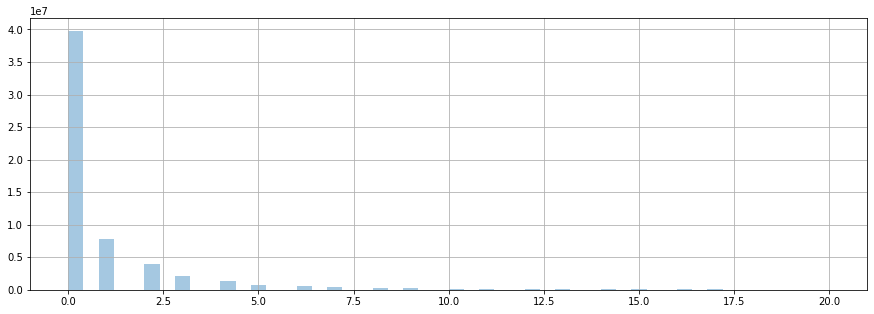

In [42]:
plt.figure(figsize=(15,5))
sns.distplot(data.query("q <= 20").q.values, kde=False)
plt.grid()
plt.show()

In [43]:
def remove_starting_zeros(dataframe):
    idxmin = dataframe.query("q > 0").index.min()
    return dataframe.loc[idxmin:, :]

In [44]:
%%time
data = (data
        .groupby(["item_id","store_id"])
        .apply(remove_starting_zeros)
        .reset_index(drop=True)
       )

CPU times: user 4min 19s, sys: 33.4 s, total: 4min 52s
Wall time: 4min 50s


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45942500 entries, 0 to 45942499
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ts_id          int16         
 1   item_id        int16         
 2   dept_id        int8          
 3   cat_id         int8          
 4   store_id       int8          
 5   state_id       int8          
 6   d              object        
 7   q              int16         
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  event_name_1   int8          
 11  event_type_1   int8          
 12  event_name_2   int8          
 13  event_type_2   int8          
 14  sell_price     float32       
 15  regular_price  float32       
 16  discount       float32       
 17  discount_porc  float32       
 18  outofstock     int8          
 19  snap           int8          
dtypes: datetime64[ns](1), float32(4), int16(4), int8(10), object(1)
memory usage: 2.1+ GB


In [46]:
data.isnull().sum(axis=0)

ts_id            0
item_id          0
dept_id          0
cat_id           0
store_id         0
state_id         0
d                0
q                0
date             0
wm_yr_wk         0
event_name_1     0
event_type_1     0
event_name_2     0
event_type_2     0
sell_price       0
regular_price    0
discount         0
discount_porc    0
outofstock       0
snap             0
dtype: int64

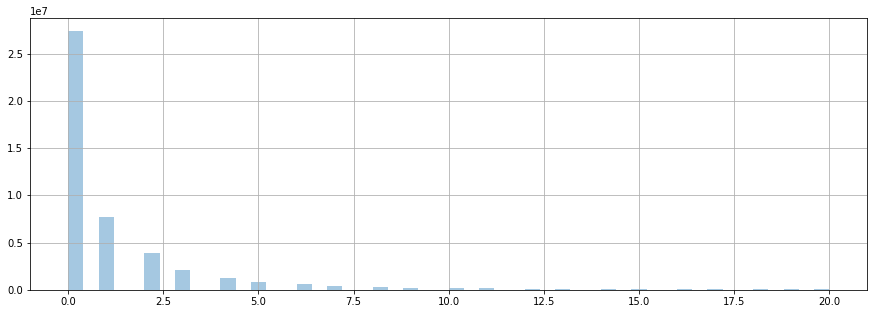

In [47]:
plt.figure(figsize=(15,5))
sns.distplot(data.query("q <= 20").q.values, kde=False)
plt.grid()
plt.show()

***

In [48]:
data.drop(["d", "wm_yr_wk"], axis=1, inplace=True)
data.rename({"date":"ds"}, axis=1, inplace=True)

***

In [60]:
# if the ts has no sales in the past 8 weeks, will be marked as out-of-stock for the prediction period.
left_date = data.ds.max() - pd.DateOffset(days=56)
no_sales_ts = (data
               .query("ds >= @left_date")
               .groupby(["ts_id"])
               .filter(lambda x: np.all(x.q==0))
               .loc[:, ["ts_id"]]
               .drop_duplicates()
              )

***
## validation and evaluation dataframes

In [ ]:
calendar_columns = ["date", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI",
                    "event_name_1", "event_type_1", "event_name_2", "event_type_2"]

valid_dataframe = (pd.concat([make_time_range("2016-04-25", "2016-05-22", "D").assign(**row)
                              for _,row in hierarchy.iterrows()], ignore_index=True)
                   .merge(calendar.loc[:, calendar_columns],
                          how="left", left_on="ds", right_on="date")
                   .merge(sell_prices, how="left")
                   .drop(["id","date","wm_yr_wk"], axis=1)
                  )

In [ ]:
valid_dataframe["outofstock"] = 0
idx = valid_dataframe.query("ts_id in @no_sales_ts.ts_id").index
valid_dataframe.loc[idx, "outofstock"] = 1

In [ ]:
valid_dataframe["snap"] = 0

idx_snap_ca = valid_dataframe.query("state_id==1 & snap_CA==1").index
valid_dataframe.loc[idx_snap_ca, "snap"] = 1

idx_snap_tx = valid_dataframe.query("state_id==2 & snap_TX==1").index
valid_dataframe.loc[idx_snap_tx, "snap"] = 2

idx_snap_wi = valid_dataframe.query("state_id==3 & snap_WI==1").index
valid_dataframe.loc[idx_snap_wi, "snap"] = 3

valid_dataframe.drop(["snap_CA", "snap_TX", "snap_WI"], axis=1, inplace=True)

In [50]:
valid_dataframe = reduce_mem_usage(valid_dataframe)

***

In [52]:
calendar_columns = ["date", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI",
                    "event_name_1", "event_type_1", "event_name_2", "event_type_2"]

eval_dataframe = (pd.concat([make_time_range("2016-05-23", "2016-06-19", "D").assign(**row)
                             for _,row in hierarchy.iterrows()], ignore_index=True)
                  .merge(calendar.loc[:, calendar_columns],
                         how="left", left_on="ds", right_on="date")
                  .merge(sell_prices, how="left")
                  .drop(["id","date","wm_yr_wk"], axis=1)
                 )

In [ ]:
eval_dataframe["outofstock"] = 0
idx = eval_dataframe.query("ts_id in @no_sales_ts.ts_id").index
eval_dataframe.loc[idx, "outofstock"] = 1

In [53]:
eval_dataframe["snap"] = 0

idx_snap_ca = eval_dataframe.query("state_id==1 & snap_CA==1").index
eval_dataframe.loc[idx_snap_ca, "snap"] = 1

idx_snap_tx = eval_dataframe.query("state_id==2 & snap_TX==1").index
eval_dataframe.loc[idx_snap_tx, "snap"] = 2

idx_snap_wi = eval_dataframe.query("state_id==3 & snap_WI==1").index
eval_dataframe.loc[idx_snap_wi, "snap"] = 3

eval_dataframe.drop(["snap_CA", "snap_TX", "snap_WI"], axis=1, inplace=True)

In [55]:
eval_dataframe = reduce_mem_usage(eval_dataframe)

***
### Saving the dataframes

In [59]:
# training data
(data
 .to_parquet("../input/train_dataframe.parquet", index=False)
)

In [60]:
# validation data
(valid_dataframe
 .to_parquet("../input/valid_dataframe.parquet", index=False)
)

In [61]:
# evaluation data
(eval_dataframe
 .to_parquet("../input/eval_dataframe.parquet", index=False)
)

***